## Kinetic Monte-Carlo algorithm for epitaxial deposition

In [1]:
import numpy                as np
import matplotlib.pyplot    as plt
import scipy.constants      as cst
import random

# Pour l'analyse des composantes connexes
from scipy.ndimage.measurements import label

# Pour l'animation
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
"CONSTANTES"
kB = cst.physical_constants['Boltzmann constant'][0]
eV = cst.physical_constants['electron volt'][0]
h  = cst.physical_constants['Planck constant'][0]

In [3]:
"PARAMETRES"
T  = 800        # Température (K)
ES = 1.3 * eV   # Energie atome-substrat (eV)
EN = 1.0 * eV   # Energie atome-voisin (eV)
L  = 50         # Nombre d'atomes sur une ligne de la grille
theta = 0.3     # Coverage max

"PROBABILITES"
F  = 0.1                # Nombre d'atomes déposés sur une colonne par seconde
t_dep = 1 / (F * L**2)  # Intervalle de temps entre deux dépôts sur la grille de L^2 atomes

D  = (2*kB*T/h) * np.exp(-ES/(kB*T))  # Nombre de sauts effectués par un atome (sans voisins) par seconde
t_diff = 1 / D                        # Intervalle de temps entre deux sauts pour un atome sans voisins

# Poids de la constante de vitesse dû aux voisins:
p0 = 1
p1 = np.exp(-1*EN/(kB*T))
p2 = np.exp(-2*EN/(kB*T))
p3 = np.exp(-3*EN/(kB*T))
p4 = np.exp(-4*EN/(kB*T))
P  = [p0, p1, p2, p3, p4]  # P[n] est la probabilité à utiliser pour n voisins
print(P)

th = 1 # Nombre max de voisins pour être autorisé à diffuser (à ajuster en fonction du EN choisi ~ en dessous de p=10-6 on fixe les atomes)

[1, 5.01504841526016e-07, 2.5150710607403444e-13, 1.2613203137432464e-19, 6.32558244057356e-26]


In [4]:
"FONCTIONS"

"Ajout d'un atome sur la colonne (i, j)"
def add_atom(i,j):
    
    C_ini = int(Classe[i,j])
    Types[C_ini].remove( (i, j) ) # retirer la colonne de la table de classes
    
    # Si le nouvel atome va dépasser ses voisins, baisser la classe de la colonne:
    if H[i,j] == H[np.mod(i-1,L), j]:
        Classe[i,j] -= 1
    if H[i,j] == H[np.mod(i+1,L), j]:
        Classe[i,j] -= 1
    if H[i,j] == H[i, np.mod(j-1,L)]:
        Classe[i,j] -= 1
    if H[i,j] == H[i, np.mod(j+1,L)]:
        Classe[i,j] -= 1
        
    C_fin = int(Classe[i,j])
    Types[C_fin].append( (i, j) ) # ajouter la colonne à la table de classes
    
    if (C_ini > th) and (C_fin <= th):
        Mobile.append( (i, j) ) 
        
        
    H[i,j] += 1  # ajouter l'atome en (i, j)
        
    # Si le nouvel atome change la classe des colonnes voisines:
    if H[i,j] == H[np.mod(i-1,L), j]:
        
        C = int(Classe[np.mod(i-1,L), j])
        Types[C].remove( (np.mod(i-1,L), j) )
        Classe[np.mod(i-1,L),j] += 1
        Types[C+1].append( (np.mod(i-1,L), j) )
        
        if C==th:
            Mobile.remove( (np.mod(i-1,L), j) ) 
        
    if H[i,j] == H[np.mod(i+1,L), j]:
        
        C = int(Classe[np.mod(i+1,L), j])
        Types[C].remove( (np.mod(i+1,L), j) )
        Classe[np.mod(i+1,L),j] += 1
        Types[C+1].append( (np.mod(i+1,L), j) )
        
        if C==th:
            Mobile.remove( (np.mod(i+1,L), j) ) 
        
    if H[i,j] == H[i, np.mod(j-1,L)]:
        
        C = int(Classe[i, np.mod(j-1,L)])
        Types[C].remove( (i, np.mod(j-1,L)) )
        Classe[i,np.mod(j-1,L)] += 1
        Types[C+1].append( (i, np.mod(j-1,L)) )
        
        if C==th:
            Mobile.remove( (i, np.mod(j-1,L)) ) 
        
    if H[i,j] == H[i, np.mod(j+1,L)]:
        
        C = int(Classe[i, np.mod(j+1,L)])
        Types[C].remove( (i, np.mod(j+1,L)) )
        Classe[i,np.mod(j+1,L)] += 1
        Types[C+1].append( (i, np.mod(j+1,L)) )
        
        if C==th:
            Mobile.remove( (i, np.mod(j+1,L)) ) 


"Suppression d'un atome sur la colonne (i, j)"        
def remove_atom(i,j):
    
    # Si la suppression change la classe des colonnes voisines:
    if H[i,j] == H[np.mod(i-1,L), j]:
        
        C = int(Classe[np.mod(i-1,L), j])
        Types[C].remove( (np.mod(i-1,L), j) )
        Classe[np.mod(i-1,L),j] -= 1
        Types[C-1].append( (np.mod(i-1,L), j) )
        
        if C==th+1:
            Mobile.append( (np.mod(i-1,L), j) ) 
        
    if H[i,j] == H[np.mod(i+1,L), j]:
        
        C = int(Classe[np.mod(i+1,L), j])
        Types[C].remove( (np.mod(i+1,L), j) )
        Classe[np.mod(i+1,L),j] -= 1
        Types[C-1].append( (np.mod(i+1,L), j) )
        
        if C==th+1:
            Mobile.append( (np.mod(i+1,L), j) ) 
        
    if H[i,j] == H[i, np.mod(j-1,L)]:
        
        C = int(Classe[i, np.mod(j-1,L)])
        Types[C].remove( (i, np.mod(j-1,L)) )
        Classe[i,np.mod(j-1,L)] -= 1
        Types[C-1].append( (i, np.mod(j-1,L)) )
        
        if C==th+1:
            Mobile.append( (i, np.mod(j-1,L)) ) 
        
    if H[i,j] == H[i, np.mod(j+1,L)]:
        
        C = int(Classe[i, np.mod(j+1,L)])
        Types[C].remove( (i, np.mod(j+1,L)) )
        Classe[i,np.mod(j+1,L)] -= 1
        Types[C-1].append( (i, np.mod(j+1,L)) )
        
        if C==th+1:
            Mobile.append( (i, np.mod(j+1,L)) ) 
        
    H[i,j] -= 1  # supprimer l'atome en (i, j)
    
    C_ini = int(Classe[i,j])
    Types[C_ini].remove( (i, j) )
        
    # Si le nouvel atome gagne des voisins, augmenter sa classe:
    if H[i,j] == H[np.mod(i-1,L), j]:
        Classe[i,j] += 1
    if H[i,j] == H[np.mod(i+1,L), j]:
        Classe[i,j] += 1
    if H[i,j] == H[i, np.mod(j-1,L)]:
        Classe[i,j] += 1
    if H[i,j] == H[i, np.mod(j+1,L)]:
        Classe[i,j] += 1
        
    C_fin = int(Classe[i,j])
    Types[C_fin].append( (i, j) )
    
    if (C_fin > th) and (C_ini <= th):
        Mobile.remove( (i, j) )


"Kinetic Monte Carlo"
def KMC():
    'Deposition'
    for S in range(0, n_dep):

        I, J = np.random.randint(L, size=2) # on choisit au hasard une colonne (I, J) sur la grille
        add_atom(I, J)                      # on y ajoute un atome
        
        # Pour suivre l'avancée du calcul:
        if ((S+1) % 10) == 0:
            print('Atomes déposés: '+str(S+1))
        
        # Pour enregistrer la surface à intervalles réguliers:
        if (S % 10) == 0: # Tous les 10 atomes déposés 
            np.savetxt('L='+str(L)+'F='+str(F)+'T='+str(T)+'theta='+str(theta)+'EN='+str(EN/eV)+'Ndep='+str(S)+'.txt', H)

        'Diffusion'
        t = 0             # reset le compteur de temps
        while t < t_dep:  # On diffuse pendant le temps t_dep avant la nouvelle déposition
            
            N = len(Mobile) # Nombre d'atomes qui peuvent bouger (P[n] non négligeable)

            t += t_diff/N # Ajout de l'intervalle de temps pour 1 saut pour le nombre d'atomes mobiles considéré
            
            i, j = random.choice(Mobile)   # on choisit au hasard un atome mobile
            C = int(Classe[i, j])          # on lit la classe de l'atome choisi

            p = P[C]    # probabilité d'accepter le saut pour la classe de l'atome choisi
            
            r = np.random.rand()
            if r < p: # si le saut est accepté

                # On déplace l'atome selon l'une des quatres directions:
                r2 = np.random.rand()
                remove_atom(i, j)
                if r2 < 0.25:
                        add_atom(np.mod(i-1, L), j)
                if 0.25 < r2 < 0.50:
                        add_atom(np.mod(i+1, L), j)
                if 0.50 < r2 < 0.75:
                        add_atom(i, np.mod(j-1, L))
                if 0.75 < r2 < 1:
                        add_atom(i, np.mod(j+1, L))
                         

In [5]:
"SIMULATION"

"Nombre total d'atomes à déposer"
n_dep = int(L**2*theta)
print('Atomes à déposer: '+str(n_dep))

'Matrice H initiale: 0 atomes partout'
H = np.ones((L,L)) * 0

'Matrice des classes initiale: 4 voisins partout'
Classe = np.ones((L,L)) * 4

'Liste des types initiale: toutes les coordonnées (i, j) dans Types[4]'
Columns = []
for i in range(0, L):
    for j in range(0, L):
        Columns.append((i, j))
Types = [[], [], [], [], Columns]  # Liste des colonnes (i, j) de classe 0, 1, 2, 3, 4

Mobile = []

'Lancer la simulation Monte-Carlo'
KMC()

'Enregistrer le résultat final'
np.savetxt('L='+str(L)+'F='+str(F)+'T='+str(T)+'theta='+str(theta)+'EN='+str(EN/eV)+'Ndep='+str(n_dep)+'.txt', H)

Atomes à déposer: 750
Atomes déposés: 10
Atomes déposés: 20
Atomes déposés: 30
Atomes déposés: 40
Atomes déposés: 50
Atomes déposés: 60
Atomes déposés: 70
Atomes déposés: 80
Atomes déposés: 90
Atomes déposés: 100
Atomes déposés: 110
Atomes déposés: 120
Atomes déposés: 130
Atomes déposés: 140
Atomes déposés: 150
Atomes déposés: 160
Atomes déposés: 170
Atomes déposés: 180
Atomes déposés: 190
Atomes déposés: 200
Atomes déposés: 210
Atomes déposés: 220
Atomes déposés: 230
Atomes déposés: 240
Atomes déposés: 250
Atomes déposés: 260
Atomes déposés: 270
Atomes déposés: 280
Atomes déposés: 290
Atomes déposés: 300
Atomes déposés: 310
Atomes déposés: 320
Atomes déposés: 330
Atomes déposés: 340
Atomes déposés: 350
Atomes déposés: 360
Atomes déposés: 370
Atomes déposés: 380
Atomes déposés: 390
Atomes déposés: 400
Atomes déposés: 410
Atomes déposés: 420
Atomes déposés: 430
Atomes déposés: 440
Atomes déposés: 450
Atomes déposés: 460
Atomes déposés: 470
Atomes déposés: 480
Atomes déposés: 490
Atomes 

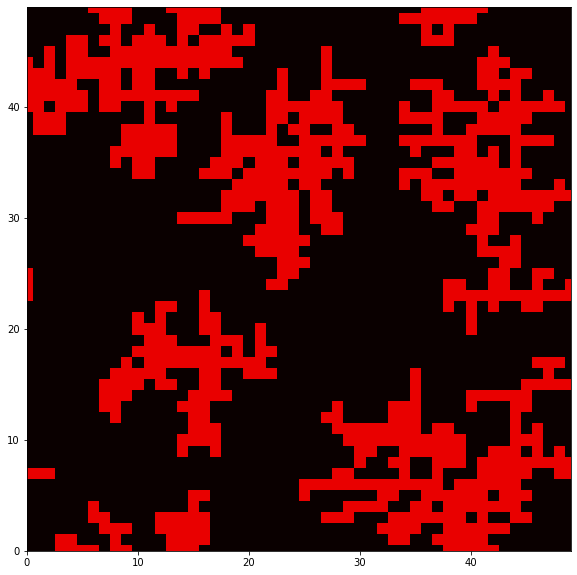

In [6]:
"RESULTATS"

H = np.loadtxt('L='+str(L)+'F='+str(F)+'T='+str(T)+'theta='+str(theta)+'EN='+str(EN/eV)+'Ndep='+str(n_dep)+'.txt')

'Tracer la surface en 2D'
%matplotlib inline
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.imshow(H, cmap='hot', vmax=3, vmin=0)

ax.set_xlim(0,L-1)
ax.set_ylim(0,L-1)

plt.show()

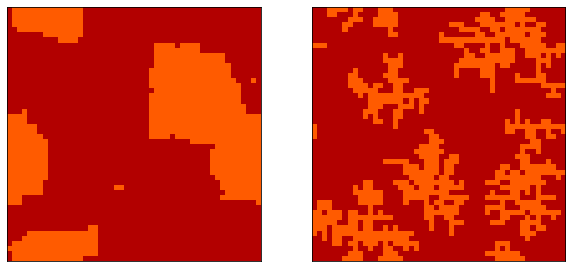

In [8]:
"ANIMATION"

frames03 = []
for k in np.linspace(0, n_dep, int(n_dep/10+1)):
    frames03.append(np.loadtxt('L='+str(L)+'F='+str(F)+'T='+str(T)+'theta='+str(theta)+'EN='+str(0.3)+'Ndep='+str(int(k))+'.txt'))
frames=np.array(frames03)

frames10 = []
for k in np.linspace(0, n_dep, int(n_dep/10+1)):
    frames10.append(np.loadtxt('L='+str(L)+'F='+str(F)+'T='+str(T)+'theta='+str(theta)+'EN='+str(1.0)+'Ndep='+str(int(k))+'.txt'))
frames=np.array(frames10)

%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 5)) # make figure

im0 = ax[0].imshow(frames03[0], cmap=plt.get_cmap('hot'), vmin=-1, vmax=3)
im1 = ax[1].imshow(frames10[0], cmap=plt.get_cmap('hot'), vmin=-1, vmax=3)

ax[0].tick_params(labelbottom=False, bottom=False, labelleft=False, left=False)
ax[1].tick_params(labelbottom=False, bottom=False, labelleft=False, left=False)

# function to update figure
def updatefig(j):
    # set the data in the axesimage object
    im0.set_array(frames03[j])
    im1.set_array(frames10[j])
    # return the artists set
    return [im0]
# kick off the animation
ani = animation.FuncAnimation(fig, updatefig, frames=range(75),
                              interval=50, blit=True)


HTML(ani.to_html5_video())


<ipython-input-9-76c838db5471>:149: RuntimeWarning: divide by zero encountered in log10
  ax2[1].scatter(np.log10(thetaval/100), np.log10(N1), s=80, color='k', marker='.')


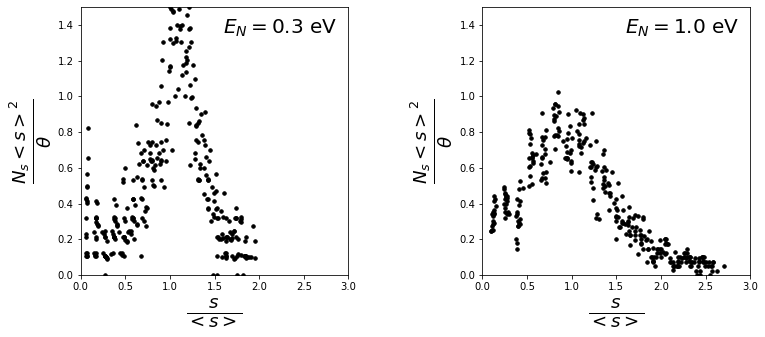

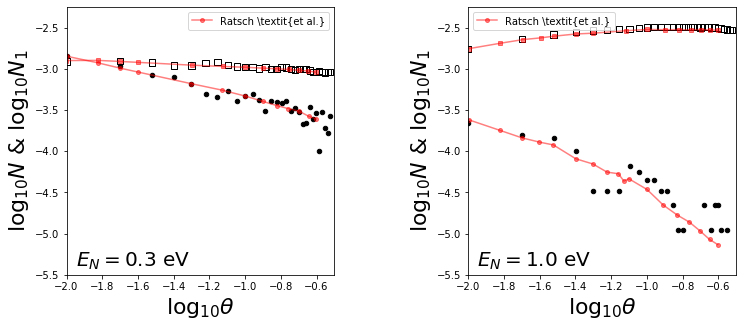

In [9]:
"ANALYSE DES DONNEES"

fig1, ax1 = plt.subplots(1, 2, figsize=(12, 5)) # Scaling des tailles d'ilôts
fig2, ax2 = plt.subplots(1, 2, figsize=(12, 5)) # Analyse temporelle

"Données de l'article - 0.3 eV"
N11eV = np.loadtxt('03eVN1.txt').T
ax2[0].plot(N11eV[0], N11eV[1], '-o', color='r', alpha=0.5, markersize=4, label=r'Ratsch \textit{et al.}')
N1eV = np.loadtxt('03eVN.txt').T
ax2[0].plot(N1eV[0], N1eV[1], '-s', color='r', alpha=0.5, markersize=4)
ax2[0].legend()

"Données de l'article - 1 eV"
N11eV = np.loadtxt('1eVN1.txt').T
ax2[1].plot(N11eV[0], N11eV[1], '-o', color='r', alpha=0.5, markersize=4, label=r'Ratsch \textit{et al.}')
N1eV = np.loadtxt('1eVN.txt').T
ax2[1].plot(N1eV[0], N1eV[1], '-s', color='r', alpha=0.5, markersize=4)
ax2[1].legend()

"Analyse du cas EN = 0.3 eV"

# Liste des valeurs de coverage à utiliser pour l'analyse temporelle
thetalist = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, \
             16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0]

for i in range(len(thetalist)):
    thetaval = thetalist[i]

    Hmap = np.loadtxt('L=300F=0.1T=800theta='+str(thetaval)+'EN=0.3.txt') # On ouvre le fichier enregistré à theta=thetaval
    
    "COMPOSANTES CONNEXES"
    graph = np.where(Hmap > 0,1,0) # graphe des ilôts: 1 si h>0, 0 sinon
    structure = [[0,1,0],[1,1,1],[0,1,0]]  # connection filter: les atomes doivent se toucher par une arête !

    'Trouver les composantes connexes'
    label_image, ncomponents = label(graph, structure)

    'Appliquer les conditions périodiques'
    for y in range(label_image.shape[0]):
        if label_image[y, 0] > 0 and label_image[y, -1] > 0:
            label_image[label_image == label_image[y, -1]] = label_image[y, 0]
    for x in range(label_image.shape[1]):
        if label_image[0, x] > 0 and label_image[-1, x] > 0:
            label_image[label_image == label_image[-1, x]] = label_image[0, x]
            
            
    "Distribution des tailles d'ilôts"
    sizes = [] # Liste des tailles > 1
    nb1   = 0  # Nombre d'îles de taille 1
    for compo in range(1, np.max(label_image)+1):
        size = np.sum(np.where(label_image==compo,1,0))
        if size != 0:
            if size == 1:
                nb1 += 1
            else:
                sizes.append(size)
            
    N1 = nb1 / (300**2) # Densité surfacique d'îles de taille 1
    
    mean = np.mean(sizes) # Taille moyenne des îles de taille > 1
    normsizes = sizes/mean # Liste des tailles normalisées
    
    histY, histX = np.histogram(normsizes, bins=18) # histY = nombre d'îles dans une bin sur l'axe s/smean
    deltaX = histX[1] - histX[0]                    # largeur d'une bin sur l'axe s/smean
    histX = histX[:-1]+deltaX/2                     # histX -> positions des milieux des bins
    
    histY = histY / (deltaX*mean) # normaliser l'histogramme par la taille de la bin (Ns = densité par unité de s, pas par unité de s/smean)
    
    Ns = histY / (300**2) # Densité surfacique d'îles de tailles (~ dans [s, s+ds])
    
    N = len(sizes) / (300**2) # Densité surfacique d'îles de taille s > 1
    
    #print('Theta sum:'+str(np.sum(Ns*(histX*mean)*deltaX*mean) + N1*1)) # recalculer theta (somme des ns*s
    
    normNs = Ns * mean**2 / (thetaval/100) # Normaliser Ns pour le scaling*
    
    if 25 >= thetaval >= 8:
        'Ajouter lhistogramme au graphe du scaling'
        ax1[0].scatter(histX, normNs, s=12, color='k')
    
    'Ajouter un point aux dynamiques temporelles'
    ax2[0].scatter(np.log10(thetaval/100), np.log10(N), s=40, color='k', marker='s', facecolors='none')
    ax2[0].scatter(np.log10(thetaval/100), np.log10(N1), s=80, color='k', marker='.')


"Analyse du cas EN = 1.0 eV"

# Liste des valeurs de coverage à utiliser pour l'analyse temporelle
thetalist = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, \
             16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0]

for i in range(len(thetalist)):
    thetaval = thetalist[i]

    Hmap = np.loadtxt('L=300F=0.1T=800theta='+str(thetaval)+'EN=1.0.txt') # On ouvre le fichier enregistré à theta=thetaval
    
    "COMPOSANTES CONNEXES"
    graph = np.where(Hmap > 0,1,0) # graphe des ilôts: 1 si h>0, 0 sinon
    structure = [[0,1,0],[1,1,1],[0,1,0]]  # connection filter: les atomes doivent se toucher par une arête !

    'Trouver les composantes connexes'
    label_image, ncomponents = label(graph, structure)

    'Appliquer les conditions périodiques'
    for y in range(label_image.shape[0]):
        if label_image[y, 0] > 0 and label_image[y, -1] > 0:
            label_image[label_image == label_image[y, -1]] = label_image[y, 0]
    for x in range(label_image.shape[1]):
        if label_image[0, x] > 0 and label_image[-1, x] > 0:
            label_image[label_image == label_image[-1, x]] = label_image[0, x]
            
            
    "Distribution des tailles d'ilôts"
    sizes = [] # Liste des tailles > 1
    nb1   = 0  # Nombre d'îles de taille 1
    for compo in range(1, np.max(label_image)+1):
        size = np.sum(np.where(label_image==compo,1,0))
        if size != 0:
            if size == 1:
                nb1 += 1
            else:
                sizes.append(size)
            
    N1 = nb1 / (300**2) # Densité surfacique d'îles de taille 1
    
    mean = np.mean(sizes) # Taille moyenne des îles de taille > 1
    normsizes = sizes/mean # Liste des tailles normalisées
    
    histY, histX = np.histogram(normsizes, bins=18) # histY = nombre d'îles dans une bin sur l'axe s/smean
    deltaX = histX[1] - histX[0]                    # largeur d'une bin sur l'axe s/smean
    histX = histX[:-1]+deltaX/2                     # histX -> positions des milieux des bins
    
    histY = histY / (deltaX*mean) # normaliser l'histogramme par la taille de la bin (Ns = densité par unité de s, pas par unité de s/smean)
    
    Ns = histY / (300**2) # Densité surfacique d'îles de tailles (~ dans [s, s+ds])
    
    N = len(sizes) / (300**2) # Densité surfacique d'îles de taille s > 1
    
    #print('Theta sum:'+str(np.sum(Ns*(histX*mean)*deltaX*mean) + N1*1)) # recalculer theta (somme des ns*s
    
    normNs = Ns * mean**2 / (thetaval/100) # Normaliser Ns pour le scaling*
    
    if 25 >= thetaval >= 8:
        'Ajouter lhistogramme au graphe du scaling'
        ax1[1].scatter(histX, normNs, s=12, color='k')
    
    'Ajouter un point aux dynamiques temporelles'
    ax2[1].scatter(np.log10(thetaval/100), np.log10(N), s=40, color='k', marker='s', facecolors='none')
    ax2[1].scatter(np.log10(thetaval/100), np.log10(N1), s=80, color='k', marker='.')
    
    
    
    
fig1.subplots_adjust(wspace=0.5)   
fig2.subplots_adjust(wspace=0.5)  
    
ax1[0].set_xlabel(r'$\frac{s}{<s>}$', fontsize=26)
ax1[0].set_ylabel(r'$\frac{N_s <s>^2}{\theta}$', fontsize=26)
ax1[0].set_xlim(0, 3)
ax1[0].set_ylim(0, 1.5)
ax1[0].text(1.6, 1.35, r'$E_N = 0.3$ eV', fontsize=20, color='k')
ax1[0].set_aspect(1.0/ax1[0].get_data_ratio(), adjustable='box')

ax1[1].set_xlabel(r'$\frac{s}{<s>}$', fontsize=26)
ax1[1].set_ylabel(r'$\frac{N_s <s>^2}{\theta}$', fontsize=26)
ax1[1].set_xlim(0, 3)
ax1[1].set_ylim(0, 1.5)
ax1[1].text(1.6, 1.35, r'$E_N = 1.0$ eV', fontsize=20, color='k')
ax1[1].set_aspect(1.0/ax1[1].get_data_ratio(), adjustable='box')

ax2[0].set_xlabel(r'$\log_{10} \theta$', fontsize=22)
ax2[0].set_ylabel(r'$\log_{10} N \ & \ \log_{10} N_1$', fontsize=22)
ax2[0].set_xlim(-2, -0.5)
ax2[0].set_ylim(-5.5, -2.25)
ax2[0].text(-1.95, -5.4, r'$E_N = 0.3$ eV', fontsize=20, color='k')
ax2[0].set_aspect(1.0/ax2[0].get_data_ratio(), adjustable='box')

ax2[1].set_xlabel(r'$\log_{10} \theta$', fontsize=22)
ax2[1].set_ylabel(r'$\log_{10} N \ & \ \log_{10} N_1$', fontsize=22)
ax2[1].set_xlim(-2, -0.5)
ax2[1].set_ylim(-5.5, -2.25)
ax2[1].text(-1.95, -5.4, r'$E_N = 1.0$ eV', fontsize=20, color='k')
ax2[1].set_aspect(1.0/ax2[1].get_data_ratio(), adjustable='box')




plt.show()

In [10]:
"ANALYSE DES DIMENSIONS FRACTALES"


'Régression linéaire'
def estimate_coef(x, y):
    # number of observations/points
    n = np.size(x)
 
    # mean of x and y vector
    m_x = np.mean(x)
    m_y = np.mean(y)
 
    # calculating cross-deviation and deviation about x
    SS_xy = np.sum(y*x) - n*m_y*m_x
    SS_xx = np.sum(x*x) - n*m_x*m_x
 
    # calculating regression coefficients
    b_1 = SS_xy / SS_xx
    b_0 = m_y - b_1*m_x
 
    return (b_0, b_1)


thetalist = [10.0, 11.0, 12.0, 13.0, 14.0, 15.0, \
                   16.0, 17.0, 18.0, 19.0, 20.0, \
                   21.0, 22.0, 23.0, 24.0, 25.0, \
                   26.0, 27.0, 28.0, 29.0, 30.0]


"CAS EN = 1.0 eV"
    
    
A1S10 = [] # Liste des dimensions fractales de la surface ds
A1P10 = [] # Liste des dimensions fractales du périmètre dp
ratio10 = [] # Liste des ratios dp/ds

# Calcul des dimensions pour chaque theta:
for theta in thetalist:
    
    L = []
    S = []
    P = []

    Hmap = np.loadtxt('L=300F=0.1T=800theta='+str(theta)+'EN=1.0.txt') # On ouvre le fichier

    "COMPOSANTES CONNEXES"
    graph = np.where(Hmap > 0,1,0) # graphe des ilôts: 1 si h>0, 0 sinon
    structure = [[0,1,0],[1,1,1],[0,1,0]]  # connection filter: les atomes doivent se toucher par une arête !

    'Trouver les composantes connexes'
    label_image, ncomponents = label(graph, structure)

    'Appliquer les conditions périodiques'
    for y in range(label_image.shape[0]):
        if label_image[y, 0] > 0 and label_image[y, -1] > 0:
            label_image[label_image == label_image[y, -1]] = label_image[y, 0]
    for x in range(label_image.shape[1]):
        if label_image[0, x] > 0 and label_image[-1, x] > 0:
            label_image[label_image == label_image[-1, x]] = label_image[0, x]
        
        
    for compo in range(1, np.max(label_image)+1):
        island = np.where(label_image==compo,1,0)
        if np.max(island) > 0:

            # spanning length of the island along x
            i1=0
            while np.max(island[i1,:]) == 0:
                i1 += 1
            i2=np.shape(island)[0]-1
            while np.max(island[i2,:]) == 0:
                i2 -= 1
            li = i2-i1+1

            # spanning length of the island along y
            j1=0
            while np.max(island[:,j1]) == 0:
                j1 += 1
            j2=np.shape(island)[0]-1
            while np.max(island[:,j2]) == 0:
                j2 -= 1
            lj = j2-j1+1

            l = max(li, lj) # max spanning length
            s = np.sum(island) # size (mass) of the island
            
            'Calcul du périmètre'
            p = 0
            perim = np.copy(island)
            for i in range(i1, i2+1):
                for j in range(j1, j2+1):
                    if island[i, j] > 0:
                        p += 1
                        # Si l'atome a 4 voisins, le retirer
                        if (island[np.mod(i-1, 300), j]>0) and (island[np.mod(i+1, 300), j]>0) \
                                    and (island[i, np.mod(j-1, 300)]>0) and (island[i, np.mod(j+1, 300)]>0):
                            p -= 1
                            perim[i, j] = 0
                            

            if li != 300 and lj != 300 and s > 1: # Pour les îles pas au bord et suffisament grandes
                L.append(l)
                S.append(s)
                P.append(p)
                
                #plt.imshow(island[i1-1:i2+2, j1-1:j2+2])
                #plt.show()
                #plt.imshow(perim[i1-1:i2+2, j1-1:j2+2])
                #plt.show()
                
    'Régression linéaire log-log'
    a0, a1 = estimate_coef(np.log10(L), np.log10(S))
    b0, b1 = estimate_coef(np.log10(L), np.log10(P))
            
    A1S10.append(a1)
    A1P10.append(b1)
    ratio10.append(b1/a1)
    
"CAS EN = 0.3 eV"

A1S03 = [] # Liste des dimensions fractales de la surface ds
A1P03 = [] # Liste des dimensions fractales du périmètre dp
ratio03 = [] # Liste des ratios dp/ds

# Calcul des dimensions pour chaque theta:
for theta in thetalist:
    
    L = []
    S = []
    P = []

    Hmap = np.loadtxt('L=300F=0.1T=800theta='+str(theta)+'EN=0.3.txt') # On ouvre le fichier

    "COMPOSANTES CONNEXES"
    graph = np.where(Hmap > 0,1,0) # graphe des ilôts: 1 si h>0, 0 sinon
    structure = [[0,1,0],[1,1,1],[0,1,0]]  # connection filter: les atomes doivent se toucher par une arête !

    'Trouver les composantes connexes'
    label_image, ncomponents = label(graph, structure)

    'Appliquer les conditions périodiques'
    for y in range(label_image.shape[0]):
        if label_image[y, 0] > 0 and label_image[y, -1] > 0:
            label_image[label_image == label_image[y, -1]] = label_image[y, 0]
    for x in range(label_image.shape[1]):
        if label_image[0, x] > 0 and label_image[-1, x] > 0:
            label_image[label_image == label_image[-1, x]] = label_image[0, x]
        
        
    for compo in range(1, np.max(label_image)+1):
        island = np.where(label_image==compo,1,0)
        if np.max(island) > 0:

            # spanning length of the island along x
            i1=0
            while np.max(island[i1,:]) == 0:
                i1 += 1
            i2=np.shape(island)[0]-1
            while np.max(island[i2,:]) == 0:
                i2 -= 1
            li = i2-i1+1

            # spanning length of the island along y
            j1=0
            while np.max(island[:,j1]) == 0:
                j1 += 1
            j2=np.shape(island)[0]-1
            while np.max(island[:,j2]) == 0:
                j2 -= 1
            lj = j2-j1+1

            l = max(li, lj) # max spanning length
            s = np.sum(island) # size (mass) of the island
            
            'Calcul du périmètre'
            p = 0
            perim = np.copy(island)
            for i in range(i1, i2+1):
                for j in range(j1, j2+1):
                    if island[i, j] > 0:
                        p += 1
                        # Si l'atome a 4 voisins, le retirer
                        if (island[np.mod(i-1, 300), j]>0) and (island[np.mod(i+1, 300), j]>0) \
                                    and (island[i, np.mod(j-1, 300)]>0) and (island[i, np.mod(j+1, 300)]>0):
                            p -= 1
                            perim[i, j] = 0
                            

            if l != 300 and l > 5: # Pour les îles pas au bord et suffisament grandes
                L.append(l)
                S.append(s)
                P.append(p)
                
                #plt.imshow(island[i1-1:i2+2, j1-1:j2+2])
                #plt.show()
                #plt.imshow(perim[i1-1:i2+2, j1-1:j2+2])
                #plt.show()
                
    'Régression linéaire log-log'
    a0, a1 = estimate_coef(np.log10(L), np.log10(S))
    b0, b1 = estimate_coef(np.log10(L), np.log10(P))
            
    A1S03.append(a1)
    A1P03.append(b1)
    ratio03.append(b1/a1)
    


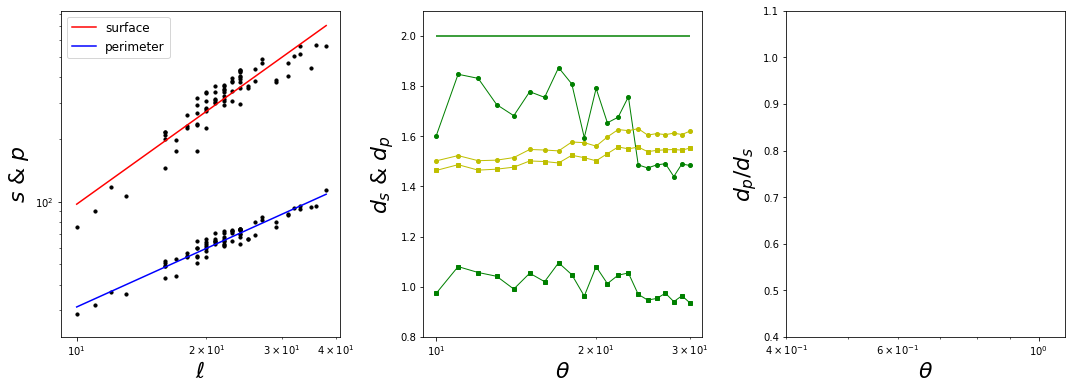

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
fig.subplots_adjust(wspace=0.3)

# Tracer un exemple de régression linéaire

ax[0].scatter(L, S, s=10, color='k')
ax[0].scatter(L, P, s=10, color='k')

X = np.linspace(min(L), max(L), 10000)
ax[0].plot(X, (10**a0) * (X**a1), color='r', label='surface')
ax[0].plot(X, (10**b0) * (X**b1), color='b', label='perimeter')

ax[0].set_xlabel('$\ell$', fontsize=22)
ax[0].set_ylabel(r'$s$ & $p$', fontsize=22)

ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[0].legend(fontsize=12)


# Tracer les dimensions en fonction de theta

ax[1].plot(thetalist, A1S03, '-o', color='g', markersize=4, linewidth=1)
ax[1].plot(thetalist, A1P03, '-s', color='g', markersize=4, linewidth=1)

ax[1].plot(thetalist, A1S10, '-o', color='y', markersize=4, linewidth=1)
ax[1].plot(thetalist, A1P10, '-s', color='y', markersize=4, linewidth=1)

ax[1].hlines(2, 10, 30, color='g')

ax[1].set_xlabel(r'$\theta$', fontsize=22)
ax[1].set_ylabel(r'$d_s$ & $d_p$', fontsize=22)

ax[1].set_xscale('log')

ax[2].set_xlim(0.4, 1.1)
ax[1].set_ylim(0.8, 2.1)



# Tracer le rapport des dimensions en fonction de theta

ax[2].plot(thetalist, ratio03, '--d', color='g', markersize=4, linewidth=1)
ax[2].plot(thetalist, ratio10, '--d', color='y', markersize=4, linewidth=1)

ax[2].set_xlabel(r'$\theta$', fontsize=22)
ax[2].set_ylabel(r'$d_p / d_s$', fontsize=22)

ax[2].set_xscale('log')

ax[2].set_ylim(0.4, 1.1)



plt.show()
